# Sign Language Recognition from Hand Gestures using Capsule Networks

## Implementation Details

1- Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
2- Code adapted from https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulenet.py
Author: Xifeng Guo, E-mail: guoxifeng1990@163.com, Github: https://github.com/XifengGuo/CapsNet-Keras
3- I benefited from the information on the following site.
https://www.kaggle.com/kmader/capsulenet-on-mnist/
4- The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
5- Adopting to other backends should be easy

Result: Loss=0.04 after 5 epochs. 

In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.
/home/tantsevov/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tantsevov/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tantsevov/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tantsevov/.local/lib/python3.6/site-packages/tenso

## Data Preprocessing

The Sign Language MNIST dataset has images of hand gestures each representing one of the 24 alphabets.

In [2]:
import cv2
import numpy as np


def skin_detector(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17, 170, 255))
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255, 180, 135))
    global_mask = cv2.bitwise_and(YCrCb_mask, HSV_mask)
    global_result = cv2.bitwise_not(global_mask)
    kernel = np.ones((3, 3), np.uint8)
    global_result = cv2.erode(global_result, kernel, iterations=1)
    global_result = cv2.dilate(global_result, kernel, iterations=1)
    return global_result

## Получение данных RSL без train_test_split

## Получение данных RSL c train_test_split

In [3]:
from sklearn.model_selection import train_test_split
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer

def proccess_x(imgs):
  x, x_orig = [], []
  for img in imgs:
    proc = skin_detector(img)
    proc = cv2.resize(proc, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
    orig = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    orig = cv2.resize(orig, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
    x.append(proc)
    x_orig.append(orig)
  x, x_orig = np.array(x) / 255, np.array(x_orig) / 255
  x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
  x_orig = x_orig.reshape(x_orig.shape[0], x_orig.shape[1], x_orig.shape[2], 1)
  return x, x_orig

def get_splitted_dataset():
  images = np.load('/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/images_E.npy', allow_pickle=True)
  labels = np.load('/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/labels_E.npy', allow_pickle=True)
  unique_val = np.unique(labels)

  label_binrizer = LabelBinarizer()
  labels = label_binrizer.fit_transform(labels)

  img_t, img_test, y_t, y_test = train_test_split(images, labels, test_size=0.2)
  img_train, img_valid, y_train, y_valid = train_test_split(img_t, y_t, test_size=0.2)

  x_train, x_orig_train = proccess_x(img_train)
  x_test, x_orig_test = proccess_x(img_test)
  x_valid, x_orig_valid = proccess_x(img_valid)
  return x_train, x_valid, x_test, x_orig_train, x_orig_valid, x_orig_test, y_train,y_valid, y_test, unique_val

## Получение данных RSL

In [5]:
x_train, x_valid, x_test, x_orig_train, x_orig_valid, x_orig_test, y_train, y_valid, y_test, unique_val = get_splitted_dataset()

print(x_train.shape, x_orig_train.shape)
print(x_valid.shape, x_orig_valid.shape)
print(x_test.shape, x_orig_test.shape)
print(unique_val)
np.save('/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/classes.npy', unique_val)

(8180, 60, 60, 1) (8180, 60, 60, 1)
(2045, 60, 60, 1) (2045, 60, 60, 1)
(2557, 60, 60, 1) (2557, 60, 60, 1)
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y']


In [6]:
np.isnan(x_train).any()

False

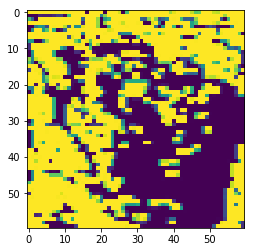

In [7]:
from matplotlib import pyplot as plt
x = x_train[0].copy()
x = x.reshape(60, 60)
plt.imshow(x)

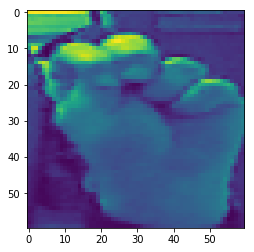

In [8]:
from matplotlib import pyplot as plt

x = x_orig_train[0].copy()
x = x.reshape(60, 60)
plt.imshow(x)

## CapsNet Architecture

### Capsule Layers

Here is the implementation of the necessary layers for the CapsuleNet. 

In [9]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """, The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')
        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
        
        c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
# last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)


### Build the Model

Here we use the layers to build up the model. The model is a bit different from a standard  X→y  model, it is  (X,y)→(y,X)  meaning it attempts to predict the class from the image, and then at the same time, using the same capsule reconstruct the image from the class. The approach appears very cGAN-like where the task of reconstructing better helps the model 'understand' the image data better.

In [10]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical


def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape, name="image")

    # Layer 1: Just a conventional Conv2D layer
    conv5 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv5, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps1 = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out')(digitcaps1)

    # Decoder network.
    #y = layers.Input(shape=(n_class,))
    #masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    #x_recon = layers.Dense(512, activation='relu')(masked)
    #x_recon = layers.Dense(1024, activation='relu')(x_recon)
    #x_recon = layers.Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x_recon)
    #x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model(x, out_caps)

In [11]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
    return K.mean(K.sum(L, 1))

### Training

In [14]:
def train(data, n_class, t, epochs=10, epoch_size_frac=1.0, num_routing=3):
    print(f'training {t} {num_routing}')
    import os
    if not os.path.exists(f'/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/{t}/{num_routing}'):
        os.makedirs(f'/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/{t}/{num_routing}')
    (x_train, y_train), (x_test, y_test) = data
    model = CapsNet(input_shape=x_train.shape[1:], n_class=n_class, num_routing=num_routing)
    # callbacks
    log = callbacks.CSVLogger(f'/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/{t}/{num_routing}/log.csv')
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))
    checkpoint = callbacks.ModelCheckpoint(f'/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/{t}/{num_routing}/best_model.h5', monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)
    # compile the model
    model.compile(optimizer='adam',
                  loss=margin_loss,
                  metrics={'out': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint])
    """

    # -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield (x_batch, y_batch)

    # Training with data augmentation. If shift_fraction=0., also no augmentation.

    model.fit_generator(generator=train_generator(x_train, y_train, 10, 0.),
                        steps_per_epoch=int(epoch_size_frac*y_train.shape[0] / 10),
                        epochs=epochs,
                        validation_data=[x_test, y_test],
                        callbacks=[log, lr_decay])
    # -----------------------------------End: Training with data augmentation -----------------------------------#

    model.save(f'/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/{t}/{num_routing}/trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')
    return model

In [ ]:
model_proc_2 = train(data=((x_train, y_train), (x_valid, y_valid)), n_class=len(unique_val), num_routing=2, t="processed", epochs=15)
model_proc_3 = train(data=((x_train, y_train), (x_valid, y_valid)), n_class=len(unique_val), num_routing=3, t="processed", epochs=15)
model_proc_4 = train(data=((x_train, y_train), (x_valid, y_valid)), n_class=len(unique_val), num_routing=4, t="processed", epochs=15)
model_proc_5 = train(data=((x_train, y_train), (x_valid, y_valid)), n_class=len(unique_val), num_routing=5, t="processed", epochs=15)
model_proc_6 = train(data=((x_train, y_train), (x_valid, y_valid)), n_class=len(unique_val), num_routing=6, t="processed", epochs=15)
model_proc_7 = train(data=((x_train, y_train), (x_valid, y_valid)), n_class=len(unique_val), num_routing=7, t="processed", epochs=15)

model_orig_2 = train(data=((x_orig_train, y_train), (x_orig_valid, y_valid)), n_class=len(unique_val), num_routing=2, t="original", epochs=30)
model_orig_3 = train(data=((x_orig_train, y_train), (x_orig_valid, y_valid)), n_class=len(unique_val), num_routing=3, t="original", epochs=30)
model_orig_4 = train(data=((x_orig_train, y_train), (x_orig_valid, y_valid)), n_class=len(unique_val), num_routing=4, t="original", epochs=30)
model_orig_5 = train(data=((x_orig_train, y_train), (x_orig_valid, y_valid)), n_class=len(unique_val), num_routing=5, t="original", epochs=30)
model_orig_6 = train(data=((x_orig_train, y_train), (x_orig_valid, y_valid)), n_class=len(unique_val), num_routing=6, t="original", epochs=30)
model_orig_7 = train(data=((x_orig_train, y_train), (x_orig_valid, y_valid)), n_class=len(unique_val), num_routing=7, t="original", epochs=30)

training processed 2

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
817/818 [============================>.] - ETA: 3s - loss: 0.4749 - acc: 0.4902

In [0]:
def test(model, data, t, num):
    x_test, y_test = data
    y_pred = model.predict(x_test, batch_size=100)
    print(y_pred)
    b = np.zeros_like(y_pred)
    b[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
    y_pred = np.around(b).astype(np.int)
    acc = np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0]
    print('-'*50)
    print(f'Test acc {t} {num}: {acc}')
    with open(f'/home/tantsevov/diploma/data/ASL Finger Spelling Dataset/{t}/{num}/acc','w') as fi:
        fi.write(f"{acc}")

### Show the results on the hold-out

In [0]:
test(model=model_proc_2, data=(x_test, y_test), t="processed", num=2)
test(model=model_proc_3, data=(x_test, y_test), t="processed", num=3)
test(model=model_proc_4, data=(x_test, y_test), t="processed", num=4)
test(model=model_proc_5, data=(x_test, y_test), t="processed", num=5)
test(model=model_proc_6, data=(x_test, y_test), t="processed", num=6)
test(model=model_proc_7, data=(x_test, y_test), t="processed", num=7)

test(model=model_orig_2, data=(x_orig_test, y_test), t="original", num=2)
test(model=model_orig_3, data=(x_orig_test, y_test), t="original", num=3)
test(model=model_orig_4, data=(x_orig_test, y_test), t="original", num=4)
test(model=model_orig_5, data=(x_orig_test, y_test), t="original", num=5)
test(model=model_orig_6, data=(x_orig_test, y_test), t="original", num=6)
test(model=model_orig_7, data=(x_orig_test, y_test), t="original", num=7)